<a href="https://colab.research.google.com/github/JairEsc/Mat_Apl_2/blob/main/Epid_AFB_MCMC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [226]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy import stats

# Simulación de los datos.

<Figure size 720x576 with 0 Axes>

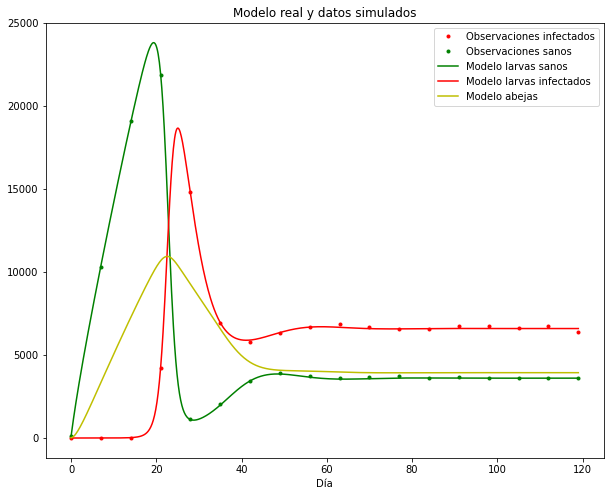

In [317]:
ruido='poisson'
Q_T=2000
alpha_T=0.25
sigma_T=0.75
mu_T=1/26.5
tau_T=1e-4
c_T=.5
true_params = np.array((Q_T, alpha_T,sigma_T,mu_T,tau_T,c_T))
def AFB(y,t,ps):
    try:
        Q = ps['Q'].value
        alpha = ps['alpha'].value
        sigma = ps['sigma'].value
        mu = ps['mu'].value
        tau = ps['tau'].value
        c = ps['c'].value
    except:
        Q,alpha,sigma,mu,tau,c = ps
    L_s,L_i,B=y
    L_s_p=Q*(L_s+B)/(L_i+L_s+B)-L_s*(alpha-sigma*(B/(L_i+L_s+B)))-L_s*B*tau*(L_i/(L_i+L_s))
    L_i_p=L_s*B*tau*(L_i/(L_i+L_s))-c*L_i*(B/(L_i+L_s+B))
    B_p=L_s*(alpha-sigma*(B/(L_i+L_s+B)))-mu*B
    if(L_i==0):
        L_i_p=0
    return np.array([L_s_p,L_i_p,B_p])
def AFB_izzy(X,t, Q,alpha,sigma,mu,tau,c):#Para no tener problemas con los parametros de las funciones.
    L_s,L_i,B=X
    L_s_p=Q*(L_s+B)/(L_i+L_s+B)-L_s*(alpha-sigma*(B/(L_i+L_s+B)))-L_s*B*tau*(L_i/(L_i+L_s))
    L_i_p=L_s*B*tau*(L_i/(L_i+L_s))-c*L_i*(B/(L_i+L_s+B))
    B_p=L_s*(alpha-sigma*(B/(L_i+L_s+B)))-mu*B
    Xsol = np.array([L_s_p,L_i_p,B_p],dtype='float64')
    Xsol = Xsol.reshape(3,)
    return(Xsol)
y0 = [100,1,20]#Condiciones iniciales
plt.figure(figsize=(10, 8))
INPUT = (y0[0],y0[1],y0[2])
t = np.linspace(0, 119, 119*7+1)
sol = odeint(AFB, y0, t, args=([Q_T, alpha_T,sigma_T,mu_T,tau_T,c_T],))
frecuancia_muestra=np.arange(0,len(t),7*7)#Apicultor hace muestreo cada 7
np.random.seed(0)#Fijamos semilla
def simular_datos(ruido):
    if (ruido=='binomial'):
        datos_larvas_infectados=np.array([stats.binom.rvs(n=int(sol[i,1]),p=0.85) for i in range(len(t))])[frecuancia_muestra]
        datos_larvas_sanas=np.array([stats.binom.rvs(n=int(sol[i,0]),p=0.80) for i in range(len(t))])[frecuancia_muestra]
        data=np.array([datos_larvas_sanas,datos_larvas_infectados]).T
    else:
        if(ruido=='poisson'):
            datos_larvas_infectados=np.random.poisson(sol[:,1])[frecuancia_muestra]# sol[:,1] son las infectadas
            datos_larvas_sanas=np.random.poisson(sol[:,0])[frecuancia_muestra]# sol[:,0] son las infectadas
            data=np.array([datos_larvas_sanas,datos_larvas_infectados]).T 
    return datos_larvas_sanas,datos_larvas_infectados,data
datos_larvas_sanas,datos_larvas_infectados,data=simular_datos(ruido)
plt.figure(figsize=(10, 8))
plt.plot(frecuancia_muestra/7,datos_larvas_infectados,'r.',label='Observaciones infectados')
plt.plot(frecuancia_muestra/7,datos_larvas_sanas,'g.',label='Observaciones sanos')
plt.plot(np.arange(0,119+1/7,1/7),sol[:,0],'g',label='Modelo larvas sanos')
plt.plot(np.arange(0,119+1/7,1/7),sol[:,1],'r',label='Modelo larvas infectados')
plt.plot(np.arange(0,119+1/7,1/7),sol[:,2],'y',label='Modelo abejas')
plt.legend()
plt.xlabel('Día')
plt.title('Modelo real y datos simulados')
plt.show()

# Ajuste numérico

In [228]:
!pip install lmfit  #Solo correr una vez

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


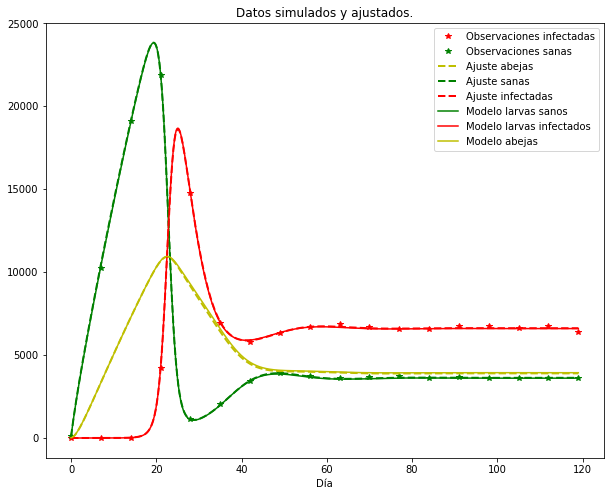

In [321]:
def modelo(t,INP,parametros):
    SOL = odeint(AFB,INPUT,t,args=(parametros,))
    return SOL
def residual(ps,ts,data):
    INP = ps['L_S_0'].value, ps['L_I_0'].value, ps['B'].value
    model = modelo(ts,INP,ps)
    return (model[frecuancia_muestra][:,0:2]-data).ravel()
from lmfit import minimize, Parameters, Parameter, report_fit
params = Parameters()
params.add('Q', value=1900, min=1500, max=2500)
params.add('alpha', value=0.2, min=0, max=0.5)
params.add('sigma', value=0.6, min=0.5, max=1)#Se puede incluir la restriccion alpha<sigma?
params.add('mu', value=0.001, min=0, max=0.5)
params.add('tau', value=0.000001, min=0, max=0.5)
params.add('c', value=0.45, min=0, max=1)
params.add('L_S_0', value=float(100), min=100, max=101)
params.add('L_I_0', value= float(1), min=1, max=2)
params.add('B', value=float(20), min=20, max=21)
result = minimize(residual, params, args=(t, data), method='leastsq',)#Ajuste numerico

#----------------------------------------#
#Grafica del ajuste
plt.figure(figsize=(10, 8))
plt.plot(frecuancia_muestra/7,data[:,1], '*r',label='Observaciones infectadas')
plt.plot(frecuancia_muestra/7,data[:,0], '*g',label='Observaciones sanas')

plt.plot(t,modelo(t,INPUT,result.params)[:,2], '--y', linewidth=2,label='Ajuste abejas');
plt.plot(t,modelo(t,INPUT,result.params)[:,0], '--g', linewidth=2,label='Ajuste sanas');
plt.plot(t,modelo(t,INPUT,result.params)[:,1], '--r', linewidth=2,label='Ajuste infectadas');
plt.plot(np.arange(0,119+1/7,1/7),sol[:,0],'g',label='Modelo larvas sanos')
plt.plot(np.arange(0,119+1/7,1/7),sol[:,1],'r',label='Modelo larvas infectados')
plt.plot(np.arange(0,119+1/7,1/7),sol[:,2],'y',label='Modelo abejas')
plt.legend()
plt.xlabel('Día')
plt.title('Datos simulados y ajustados.')
plt.show()


# Definición de distribuciones apriori

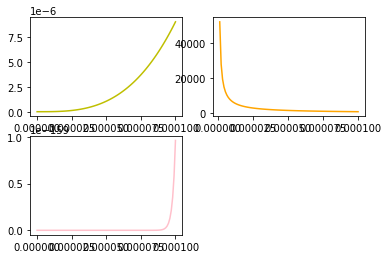

In [356]:
#Retomamos los parametros que se obtienen del ajuste.
Q_0=result.params['Q'].value
alpha_0=result.params['alpha'].value
sigma_0=result.params['sigma'].value
mu_0=result.params['mu'].value
tau_0=result.params['tau'].value
c_0=result.params['c'].value
L_S_0=100.
L_I_0=1.
B_0=20.
par1=[100*Q_0,0,1/100]  #hiperparametros para Q
par2=[10*alpha_0,0,1/10]  #hiperparametros para alpha
par3=[10*sigma_0,0,1/10]  #hiperparametros para sigma
par4=[100*mu_0,0,1/100]  #hiperparametros para mu
par5=[1000*tau_0,0,1/1000]  #hiperparametros para tau
par6=[100*c_0,0,1/100]  #hiperparametros para c
def logaprioris(theta):
    Q=Q_0
    alpha=alpha_0
    sigma=sigma_0
    mu,tau,c = theta
    dmu = stats.gamma.logpdf(mu,par4[0],par4[1],par4[2])
    dtau = stats.gamma.logpdf(tau,par5[0],par5[1],par5[2])
    dc = stats.gamma.logpdf(c,par6[0],par6[1],par6[2])
    return(dmu+dtau+dc)
def minuslogposterior(theta):
  return(-(logaprioris(theta)+logverosimilitud(theta)))
x = np.linspace(0., 0.0001,100)
prev4 = stats.gamma.pdf(x, par4[0],par4[1],par4[2])
prev5 = stats.gamma.pdf(x, par5[0],par5[1],par5[2])
prev6 = stats.gamma.pdf(x, par6[0],par6[1],par6[2])
fig = plt.figure()

plt.subplot(2, 2, 1)
plt.plot(x, prev4, 'y', label='previa ')

plt.subplot(2, 2, 2)
plt.plot(x, prev5, 'orange', label='previa ')

plt.subplot(2, 2, 3)
plt.plot(x, prev6, 'pink', label='previa ')


plt.show()


In [355]:
#### verosimilitud
def logverosimilitud(theta):
    Q=Q_0
    alpha=alpha_0
    sigma=sigma_0
    mu,tau,c = theta
    dias = 119
    t = np.arange(0,120,7)  ## vector de tiempos
    Xt =  odeint(func=AFB_izzy, y0=np.array([L_S_0,L_I_0,B_0]), t=t, args=(Q, alpha,sigma,mu,tau,c))
    ### Incidencia
    #Inc = np.diff(Xt[:,3])#Valores de incidencia diaria.
    vers = stats.poisson.logpmf(data[:,1], Xt[:,1])#Suponiendo que dado theta, los datos siguen distribucion 
            #Poisson de parámetro dado por el valor obtenido en la solución de la ODE
    ver = np.sum(vers)
    return(ver)
#### Posterior (Es más fácil trabajar con -log(Posterior))



In [357]:
from scipy.optimize import minimize
def menosloglikelihood(theta):
    return -logverosimilitud(theta)
bnds = ((0.01,0.1),(0.00001, 0.2),(0.1,0.9))
xp0=minimize(fun=menosloglikelihood,x0=[0.037,1e-4,0.5],bounds=bnds).x

In [358]:
print(xp0)
print(mu_0)
print(tau_0)
print(c_0)

[3.70805602e-02 9.88294988e-05 5.00511490e-01]
0.04103048761188505
9.992449562526429e-05
0.5006176684783156


In [326]:
import pytwalk#Añadir el archivo .py a los archivos de colab

array([2.01626806e+03, 2.42665912e-01, 7.84664633e-01, 1.28716471e-02,
       7.01322965e-03, 5.76136100e-01])

In [360]:
np.random.seed(1)

T=int(1e4) #iterations
bi=int(0.15* T)#calentamiento
tchain = pytwalk.pytwalk( n=3, U=minuslogposterior, )
tchain.Run( T=T , x0=np.array([mu_0,tau_0,c_0]), xp0=xp0,)

pytwalk: Running the twalk with 10000 iterations .  Fri, 02 Dec 2022, 02:12:42.
       Finish in approx. 2 min and 13 sec.
pytwalk:       6144 iterations so far. Finish in approx. 18 sec.
pytwalk: finished, Fri, 02 Dec 2022, 02:13:31.


1

AutoMaxlag: maxlag= 201.
Acceptance rates for the Walk, Traverse, Blow and Hop kernels:[0.24235006 0.15386179 0.         0.        ]
Global acceptance rate: 0.19450
AutoMaxlag: maxlag= 201.
Integrated Autocorrelation Time:    92.4, IAT/n:    30.8


matrix([[92.38915992]])

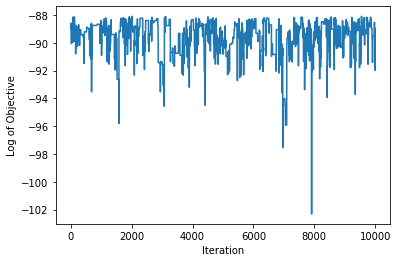

In [361]:
tchain.IAT()
tchain.Ana()

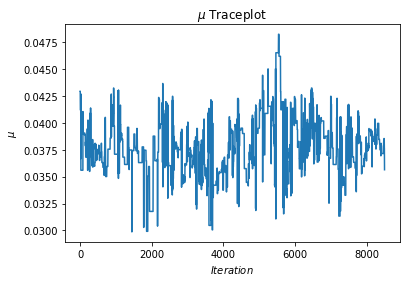

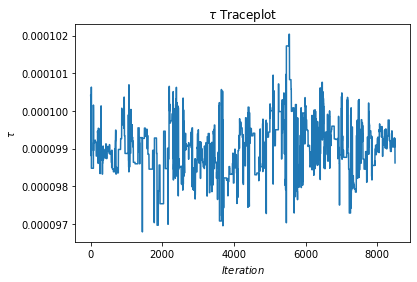

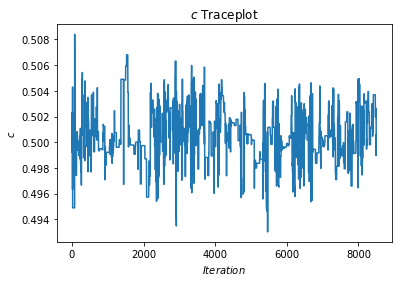

In [362]:
from scipy.stats.mstats import mquantiles
import statsmodels.api as sm
toutput=tchain.Output[ bi: ,: ] #output considerando el calentamiento

mu_s=toutput[:,0]
tau_s=toutput[:,1]
c_s=toutput[:,2]

#Trace plots after burn in
plt.plot(toutput[:,0])
plt.xlabel( r'$Iteration$' )
plt.ylabel( r'$\mu$' )
plt.title( r'$\mu$'+' Traceplot' )
plt.show()

plt.plot(toutput[:,1])
plt.xlabel( r'$Iteration$' )
plt.ylabel( r'$\tau$' )
plt.title( r'$\tau$'+' Traceplot' )
plt.show()

plt.plot(toutput[:,2])
plt.xlabel( r'$Iteration$' )
plt.ylabel( r'$c$' )
plt.title( r'$c$'+' Traceplot' )
plt.show()

plt.show()

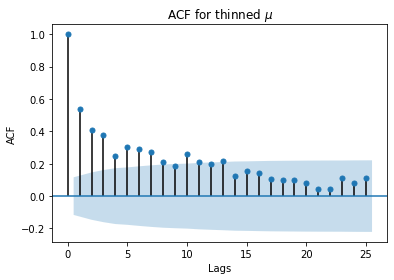

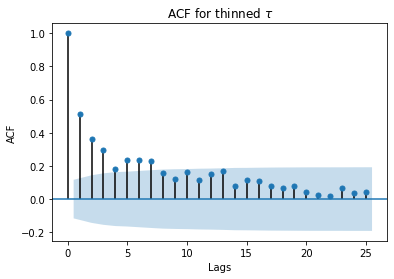

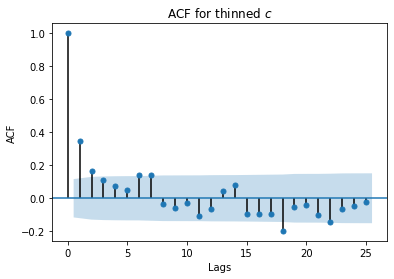

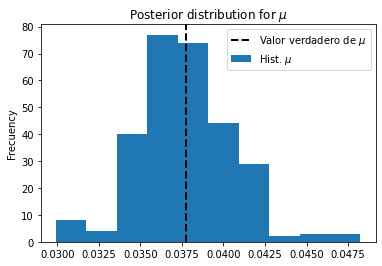

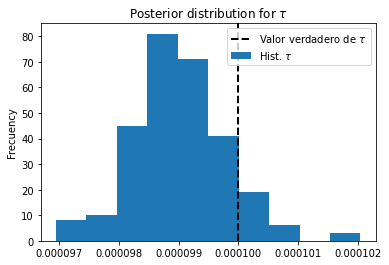

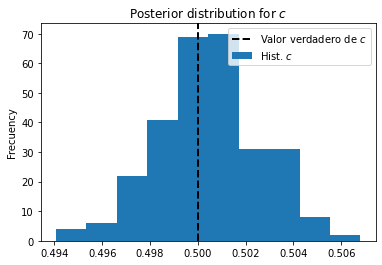

In [373]:

#thin the chain 
tau=30#
indexes=np.arange(start=0,stop=T-bi, step=tau)

mus=mu_s[indexes]
taus=tau_s[indexes]
cs=c_s[indexes]
###########plotting the ACF for beta################
sm.graphics.tsa.plot_acf(mus)
plt.xlabel('Lags') 
# naming the y axis 
plt.ylabel('ACF') 
plt.title(r'ACF for thinned $\mu$')
plt.show()
###########plotting the ACF for sigma ################
sm.graphics.tsa.plot_acf(taus)
plt.xlabel('Lags') 
# naming the y axis 
plt.ylabel('ACF') 
plt.title(r'ACF for thinned $\tau$')
plt.show()
###########plotting the ACF for sigma ################
sm.graphics.tsa.plot_acf(cs)
plt.xlabel('Lags') 
# naming the y axis 
plt.ylabel('ACF') 
plt.title(r'ACF for thinned $c$')
plt.show()
######## plotting the histogram of the chains after thinning ###########
plt.hist(mus,bins=10,density=False,label=r'Hist. $\mu$')
plt.axvline(mu_T, color='k', linestyle='dashed', linewidth=2,label=r'Valor verdadero de $\mu$')
plt.ylabel("Frecuency")
plt.title(r"Posterior distribution for $\mu$")
plt.legend()
plt.show()
plt.hist(taus,bins=10,density=False,label=r'Hist. $\tau$')
plt.axvline(tau_T, color='k', linestyle='dashed', linewidth=2,label=r'Valor verdadero de $\tau$')
plt.ylabel("Frecuency")
plt.title(r"Posterior distribution for $\tau$")
plt.legend()
plt.show()
plt.hist(cs,bins=10,density=False,label=r'Hist. $c$')
plt.axvline(c_T, color='k', linestyle='dashed', linewidth=2,label=r'Valor verdadero de $c$')
plt.ylabel("Frecuency")
plt.title(r"Posterior distribution for $c$")
plt.legend()
plt.show()